# Passo 1

## Importações necessárias

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Definição de funções

### Função de leitura

In [4]:
def load_spam_collection(data_path, seed=123):
    spamfilter_df = pd.read_csv(data_path, delimiter='\t', header=None)
    spamfilter_df.columns = ['label', 'message']
    
    ''' 
        All labels were changed to the following classification: 
        spam is converted to 1 and ham to 0.
    '''
    spamfilter_df['label'] = spamfilter_df['label'].apply(
        lambda x: 1 if(x == 'spam')
        else 0
    )

    '''
    Adding an additional column that represents the number of letters 
    per message, thus creating a table that provides the sample size information.
    '''
    spamfilter_df['sample_length'] = spamfilter_df['message'].apply(lambda x: len(x))

    return spamfilter_df

### Funções de análise de dados

In [5]:
def get_num_documents(spamfilter_df):
    return spamfilter_df.count()['label']


def get_num_words_per_document(spamfilter_df):
    sample_message = spamfilter_df['message'].tolist()
    num_words = [len(s.split()) for s in sample_message]
    return np.median(num_words)


def get_num_classes(spamfilter_df):
    return spamfilter_df.nunique()['label']


def plot_sample_length_distribuition(spamfilter_df):
    sns.histplot(
        spamfilter_df['sample_length'],
        kde=True,
        bins=50,
        color='blue'
    )


def plot_class_distribuition(spamfilter_df):
    labels = spamfilter_df['label'].value_counts()
    lp = labels.plot(kind='barh', color=['#66c2a5', '#fc8d62'])
    lp.set_yticks([0, 1])
    lp.set_yticklabels(['Ham', 'Spam'])

## Aplicando a análise

In [47]:
data_path = "data/SMSSpamCollection"  # You may need to change the directory on your machine for it to work.
spam_df = load_spam_collection(data_path)

spam_df.head()

In [48]:
num_doc = get_num_documents(spam_df)
print(f"Número total de documentos: {num_doc}")

In [49]:
num_word_per_document = get_num_words_per_document(spam_df)
print(f"Número médio de palavras por documento: {num_word_per_document}")

In [50]:
num_classes = get_num_classes(spam_df)
print(f"Número de classes: {num_classes}")

In [14]:
plot_sample_length_distribuition(spam_df)

In [13]:
plot_class_distribuition(spam_df)

# Passo 2

## Importações necessárias

In [12]:
import spacy
import nltk
from nltk.stem import WordNetLemmatizer # utilizado para fazer lematização do texto
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re # biblioteca para utilizar expressão regulares
from wordcloud import WordCloud # biblioteca para criar uma núvem de palavras
import contractions # usado para expandir as possíveis contrações do texto

## Preprando dados para pré-processamento

In [15]:
nlp = spacy.load("en_core_web_sm")
stop_words = STOP_WORDS
# stop_words

In [16]:
punctuation = string.punctuation
# punctuation

In [17]:
nltk.download('wordnet') # download para fazer a lematização do texto usando WordNetLematizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Função que pré-processa os dados

In [18]:
def contraction_text(texts):
    ''' 
        This function is used to expand the possible hiring of some words in the text
    '''
    
    expanded_text = []
    for word in texts.split():
        expanded_text.append(contractions.fix(word))

    texts = ' '.join(expanded_text)
    
    return texts

In [19]:
def lemmatizer_text(texts):
    ''' 
    function responsible for lemmatizing the text
    '''
    
    lemmatizer = WordNetLemmatizer()
    
    word_token = texts.split()
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in word_token]

    texts = ' '.join(lemmas)

    return texts

In [20]:
def processing(texts):
    texts = contraction_text(texts)
    texts = lemmatizer_text(texts)
    
    result = []
    pos_tag = ['ADJ', 'NOUN', 'VERB', 'PROPN'] # vetor que permite escolher somente entre adjetivos, substantivos, verbos e pronomes
    text = re.sub(r'(https?://[^\s\n\r]+|www\.[^\s\n\r]+|[0-9@#&!?:,.\)\(;])', '', texts) # expressão regular que retira do texto todos os números, simbolos (&#;) e URL
    doc = nlp(text.lower())

    for token in doc:
        if(token.text in stop_words or token.text in punctuation or len(token.text) <= 3 or token.text == "ltgt"):
            continue
        
        if(token.pos_ in pos_tag):
            result.append(token.text)
        
        text = ' '.join(str(element) for element in result if not element.isdigit())
    
    return text

## Aplicando o pré-processamento

In [21]:
spam_df.message = spam_df.message.astype(str)
spam_df['processed_message'] = spam_df['message'].apply(processing)

spam_df.head()

,label,message,sample_length,processed_message
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,29,joking
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp final tkts text receive e...
3,0,U dun say so early hor... U c already then say...,49,early
4,0,"Nah I don't think he goes to usf, he lives aro...",61,think live


## Vizualização do resultado final

In [22]:
total_message = spam_df['processed_message'].values
result_total_message = ''

for word in total_message:
    result_total_message += word + " "

# result_total_message

In [51]:
'''
Vizualizando o resultado final do pré-processamento
com núvem de palavras
'''
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(WordCloud().generate(result_total_message))

'\nVizualizando o resultado final do pré-processamento\ncom núvem de palavras\n# '

# Passo 3

## Importações necessárias

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Dados separados para treino e testes

In [25]:
'''
80% para treino e 20% para teste. Mantendo a proporção de emails spam e ham.
Utilizando para isso o parâmetro stratify.
'''

X_train, X_test, y_train, y_test = train_test_split(
    spam_df['processed_message'],
    spam_df['label'],
    test_size=0.2,
    stratify=spam_df['label'],
    random_state=42
)

X_train = X_train.tolist()
X_test = X_test.tolist()

## Função de vetorização que utiliza TF-IDF

In [26]:
def tfid_vectorize(X_train, X_test):
    vectorizer = TfidfVectorizer()

    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)

    return x_train, x_test

In [27]:
vecX_train, vecX_test = tfid_vectorize(X_train, X_test)

# Passo 4

## Importações necessárias

In [37]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn import svm
import seaborn as sns

## Vizualização dos dados de treinamento

In [46]:
'''
Como o  TF-IDF gera uma representação de alta dimensão, 
foi utilizado a técnica PCA (Principal Component Analysis): 
Reduz as dimensões mantendo a maior variância dos dados e ajuda
a visualizar a distribuição. Para, portanto, determinar 
se os dados têm uma relação linear ou polinomial
'''
pca = PCA(n_components=2)
vecX_pca = pca.fit_transform(vecX_train.toarray())

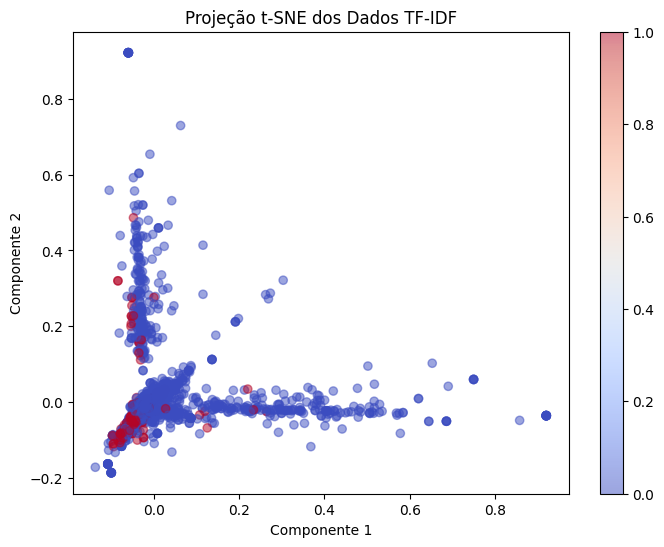

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(vecX_pca[:, 0], vecX_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title('Projeção t-SNE dos Dados TF-IDF')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar()
plt.show()

## Treinamento do modelo SVM

In [40]:
model_spam_filtter = svm.SVC(kernel='linear', C=1.0)
model_spam_filtter.fit(vecX_train, y_train)

SVC(kernel='linear')

In [52]:
y_pred = model_spam_filtter.predict(vecX_test)

# y_pred

In [53]:
y_test = np.array(y_test.tolist())

# y_test

## Métricas do modelo de classificação SVM

In [43]:
model_spam_filtter.score(vecX_test, y_test)

0.9713004484304932

In [44]:
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       966
        spam       0.94      0.84      0.89       149

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

